In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from typing import Optional, List, Dict, Any

from panovlm.model import PanoramaVLM
from panovlm.processors.image import PanoramaImageProcessor

def denormalize(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tensor = tensor.clone().permute(1, 2, 0).numpy()
    tensor = std * tensor + mean
    tensor = np.clip(tensor, 0, 1)
    return tensor

def visualize_views(
    pixel_values: torch.Tensor,
    title: str,
    *,  # [핵심 수정] 이 뒤의 인자는 반드시 키워드로만 전달해야 함
    titles: Optional[List[str]] = None,
    filename: Optional[str] = None,
    show_plot: bool = False
):
    """
    Create and save or show a visualization of the processed views.
    Optional arguments after '*' must be passed as keyword arguments.
    """
    if not filename and not show_plot:
        print("Warning: No action taken. Either 'filename' must be provided or 'show_plot' must be True.")
        return

    views = pixel_values.squeeze(0)
    num_views = views.shape[0]
    
    if num_views <= 4:
        nrows, ncols = 1, num_views
    else:
        nrows = 1
        ncols = math.ceil(num_views / 1)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4 + 1))
    axes = np.ravel(axes)
    
    fig.suptitle(title, fontsize=16)
    
    for i in range(num_views):
        view_tensor = views[i]
        img = denormalize(view_tensor)
        axes[i].imshow(img)
        axes[i].axis('off')
        if titles and i < len(titles):
            axes[i].set_title(titles[i])

    for i in range(num_views, len(axes)):
        axes[i].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    if filename:
        plt.savefig(filename)
        print(f"Saved visualization to {filename}")
    
    if show_plot:
        plt.show()

    plt.close(fig)

checkpoint_path = 'runs/siglipv2qwen25Instruct_local_e2p_finetune_mlp/best.ckpt'
# 설정 시스템을 통한 모델 로딩
model = PanoramaVLM.from_checkpoint(checkpoint_path, device="auto")
model.eval()

sample_image = "data/quic360/downtest/images/26286679561_2bc4360f7d_f.jpg"
sample_text = "이 사진에서 가장 눈에 띄는 것은 무엇인가요?"

/data/3_lib/miniconda3/envs/panovlm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🚀 PanoramaVLM 체크포인트 로딩: runs/siglipv2qwen25_e2p_finetune_mlp/best.ckpt
📂 체크포인트 로딩 중...


/data/1_personal/4_SWWOO/panollava/panovlm/model.py:1786: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device_obj)


🔍 설정 파일 감지 실패 - 하이퍼파라미터에서 생성
🛠️  모델 파라미터:
   - vision_name: google/siglip2-base-patch16-224
   - language_model_name: Qwen/Qwen2.5-0.5B-Instruct
   - resampler_type: mlp
   - latent_dimension: 768
   - vicreg_loss_weight: 0.0
   - vicreg_overlap_ratio: 0.5
   - max_text_length: 256
   - use_vicreg_local: False
   - vicreg_local_weight: 0.5
   - vicreg_local_inv_weight: 1.0
   - vicreg_local_var_weight: 1.0
   - vicreg_local_cov_weight: 0.01
   - vicreg_local_inv_type: l2
   - vicreg_local_gamma: 1.0
   - config: ModelConfig(vision=google/siglip2-base-patch16-224, language=Qwen/Qwen2.5-0.5B-Instruct, dim=768)
🏗️  모델 인스턴스 생성 중...
[Model] Using provided ModelConfig: ModelConfig(vision=google/siglip2-base-patch16-224, language=Qwen/Qwen2.5-0.5B-Instruct, dim=768)
[Tokenizer Setup] Warning: No bos_token defined
[Tokenizer Setup] Warning: No unk_token defined
[Tokenizer Setup] Added 1 special tokens: ['<|vision|>', '<|endoftext|>']
[Tokenizer Setup] Resized embeddings: 151936 -> 151666
[Text

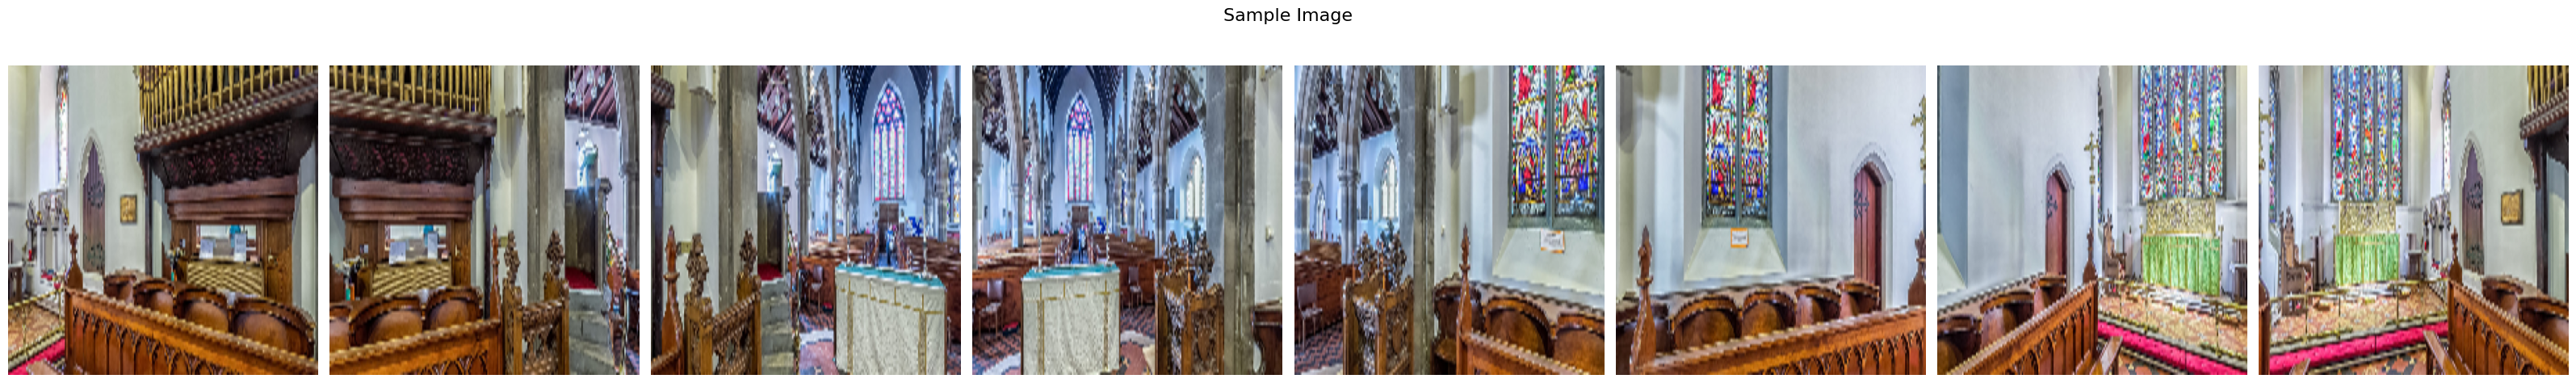

In [2]:

img_proc = PanoramaImageProcessor(
    image_size    =(224, 224),
    crop_strategy ="e2p",   # 또는 "e2p" / "cubemap" /"anyres"/"sliding_window"
    fov_deg       =90,
    overlap_ratio =0.5,
    normalize= True,
    anyres_max_patches=8
)

img = img_proc(sample_image)
img = img.unsqueeze(0)  # 배치 차원 추가
visualize_views(img, title="Sample Image", show_plot=True)

In [3]:
batch_size, num_views, normalized_pixels = model._normalize_pixel_values(img.cuda())
print(f"Batch size: {batch_size}, Number of views: {num_views}, Normalized pixels shape: {normalized_pixels.shape}")

last_hidden_states = model._extract_vision_features(
    pixel_values=normalized_pixels,
    batch_size=batch_size,
    num_views=num_views
)
print(f"Last hidden states shape: {last_hidden_states.shape}")
last_hidden_states = last_hidden_states.cpu().detach().numpy()

Batch size: 1, Number of views: 8, Normalized pixels shape: torch.Size([1, 8, 3, 224, 224])
Last hidden states shape: torch.Size([8, 196, 768])


PCA 모델 학습 및 RGB 변환 완료. (공통 스케일링: True)
▶ Hidden-space 유사도 (MSE, Cosine, CKA, Hungarian, Warp-OCS):
  Pair (0, 1): MSE=0.0813, Cos=0.9593, CKA=0.9699, Hung=0.9751
  Pair (1, 2): MSE=0.0777, Cos=0.9611, CKA=0.9709, Hung=0.9760
  Pair (2, 3): MSE=0.0621, Cos=0.9690, CKA=0.9788, Hung=0.9778
  Pair (3, 4): MSE=0.0641, Cos=0.9679, CKA=0.9785, Hung=0.9793
  Pair (4, 5): MSE=0.0671, Cos=0.9664, CKA=0.9767, Hung=0.9782
  Pair (5, 6): MSE=0.0854, Cos=0.9573, CKA=0.9650, Hung=0.9780
  Pair (6, 7): MSE=0.0587, Cos=0.9706, CKA=0.9789, Hung=0.9742
  Pair (7, 0): MSE=0.0478, Cos=0.9761, CKA=0.9842, Hung=0.9823
▶ Hidden-space 유사도 (MSE, Cosine, CKA, Hungarian, Warp-OCS):
  Pair (0, 1): MSE=0.0813, Cos=0.9593, CKA=0.9699, Hung=0.9751, OCS=0.5271
시각화 저장: siglipv2qwen25_e2p_finetune_mlp.png


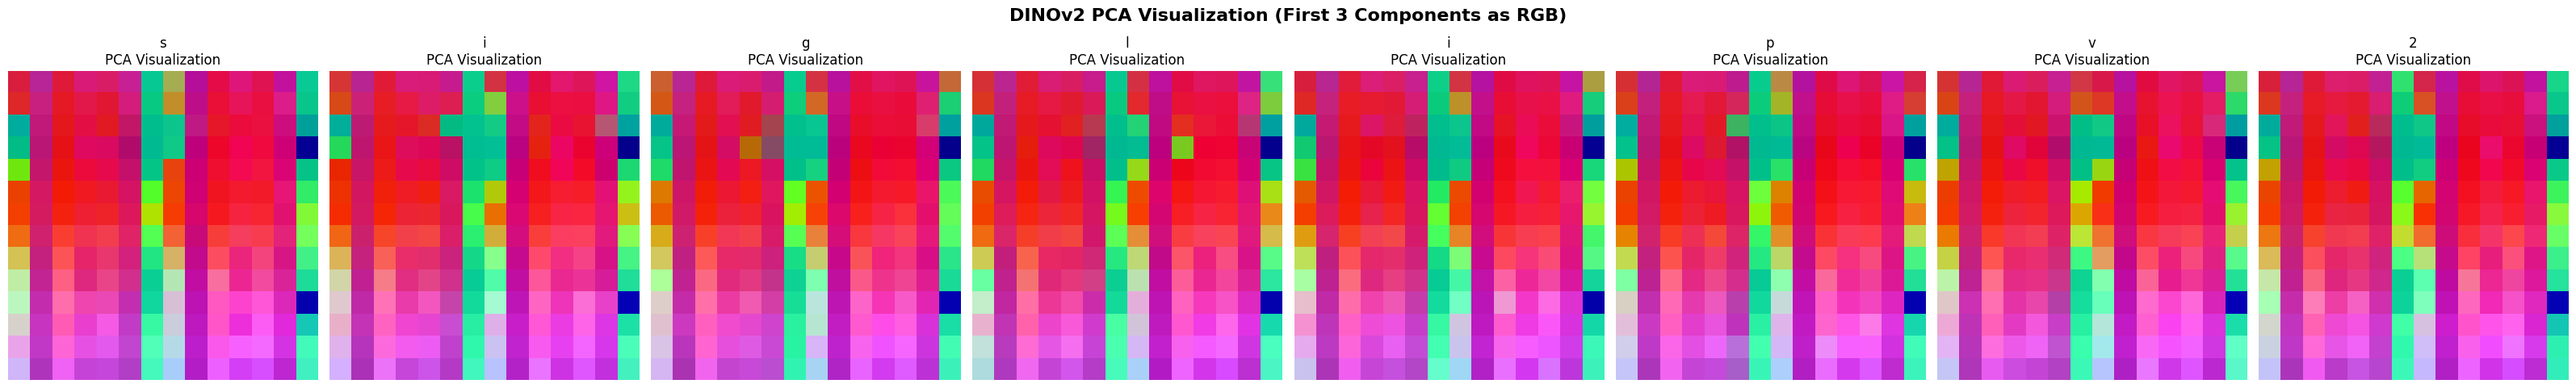


=== PCA 분석 결과 ===
주성분 1 설명 분산: 55.40%
주성분 2 설명 분산: 13.98%
주성분 3 설명 분산: 7.94%
총 설명 분산 (상위 3개): 77.32%
▶ Hidden-space 유사도 (MSE, Cosine, CKA, Hungarian, Warp-OCS):
  Pair (0, 1): MSE=0.0813, Cos=0.9593, CKA=0.9699, Hung=0.9751, OCS=0.5271
  Pair (1, 2): MSE=0.0777, Cos=0.9611, CKA=0.9709, Hung=0.9760, OCS=0.4247
  Pair (2, 3): MSE=0.0621, Cos=0.9690, CKA=0.9788, Hung=0.9778, OCS=0.5185
  Pair (3, 4): MSE=0.0641, Cos=0.9679, CKA=0.9785, Hung=0.9793, OCS=0.4963
  Pair (4, 5): MSE=0.0671, Cos=0.9664, CKA=0.9767, Hung=0.9782, OCS=0.4671
  Pair (5, 6): MSE=0.0854, Cos=0.9573, CKA=0.9650, Hung=0.9780, OCS=0.4759
  Pair (6, 7): MSE=0.0587, Cos=0.9706, CKA=0.9789, Hung=0.9742, OCS=0.5941
  Pair (7, 0): MSE=0.0478, Cos=0.9761, CKA=0.9842, Hung=0.9823, OCS=0.5583
▶ PCA-RGB 유사도 (MSE, SSIM, LPIPS):
LPIPS 모델을 로딩합니다...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/data/3_lib/miniconda3/envs/panovlm/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/3_lib/miniconda3/envs/panovlm/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /data/3_lib/miniconda3/envs/panovlm/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth
⚠️ LPIPS 연산 실패, SSIM으로 대체: Given input size: (64x2x2). Calculated output size: (64x0x0). Output size is too small
  Pair (0, 1): MSE=0.0104, SSIM=0.9032, LPIPS=0.9032
⚠️ LPIPS 연산 실패, SSIM으로 대체: Given input size: (64x2x2). Calculated output size: (64x0x0). Output size is too small
  Pair (1, 2): MSE=0.0097, SSIM=0.9384, LPIPS=0.9384
⚠️ LPIPS 연산 실패, SSIM으로 대체: Given input size: (64x2x2). Calculated output size: (64x0x0). Output size is too small
  Pair (2, 3): MSE=0.0077, SSIM=0.9498, LPIPS=0.9498
⚠️ LPIPS 연산 실패, SSIM으로 대체: Given input size: (64x2x2). Calculated output size: (64x0x0). Output size is too small
  Pair (3, 4): MSE=0.0075, SSIM=0.9442, LPIPS=0.9442
⚠️ LPIPS 연산 실패, SSIM으로 대체: Given input size: (64x2x2). Calculated output size: (64x0x0). Output size is too small
  Pair (4, 5): MSE=0.0076, SSIM=0.9600, LPIPS=0.9600
⚠️ LPIPS 연산 실패, SSIM으로 대체: Given input size: (64x2x2

/data/3_lib/miniconda3/envs/panovlm/lib/python3.12/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path

대시보드 저장됨: siglipv2qwen25_e2p_finetune_mlp_dashboard.png


/data/1_personal/4_SWWOO/panollava/panovlm/vis/dino.py:615: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # 전체적인 레이아웃 조정


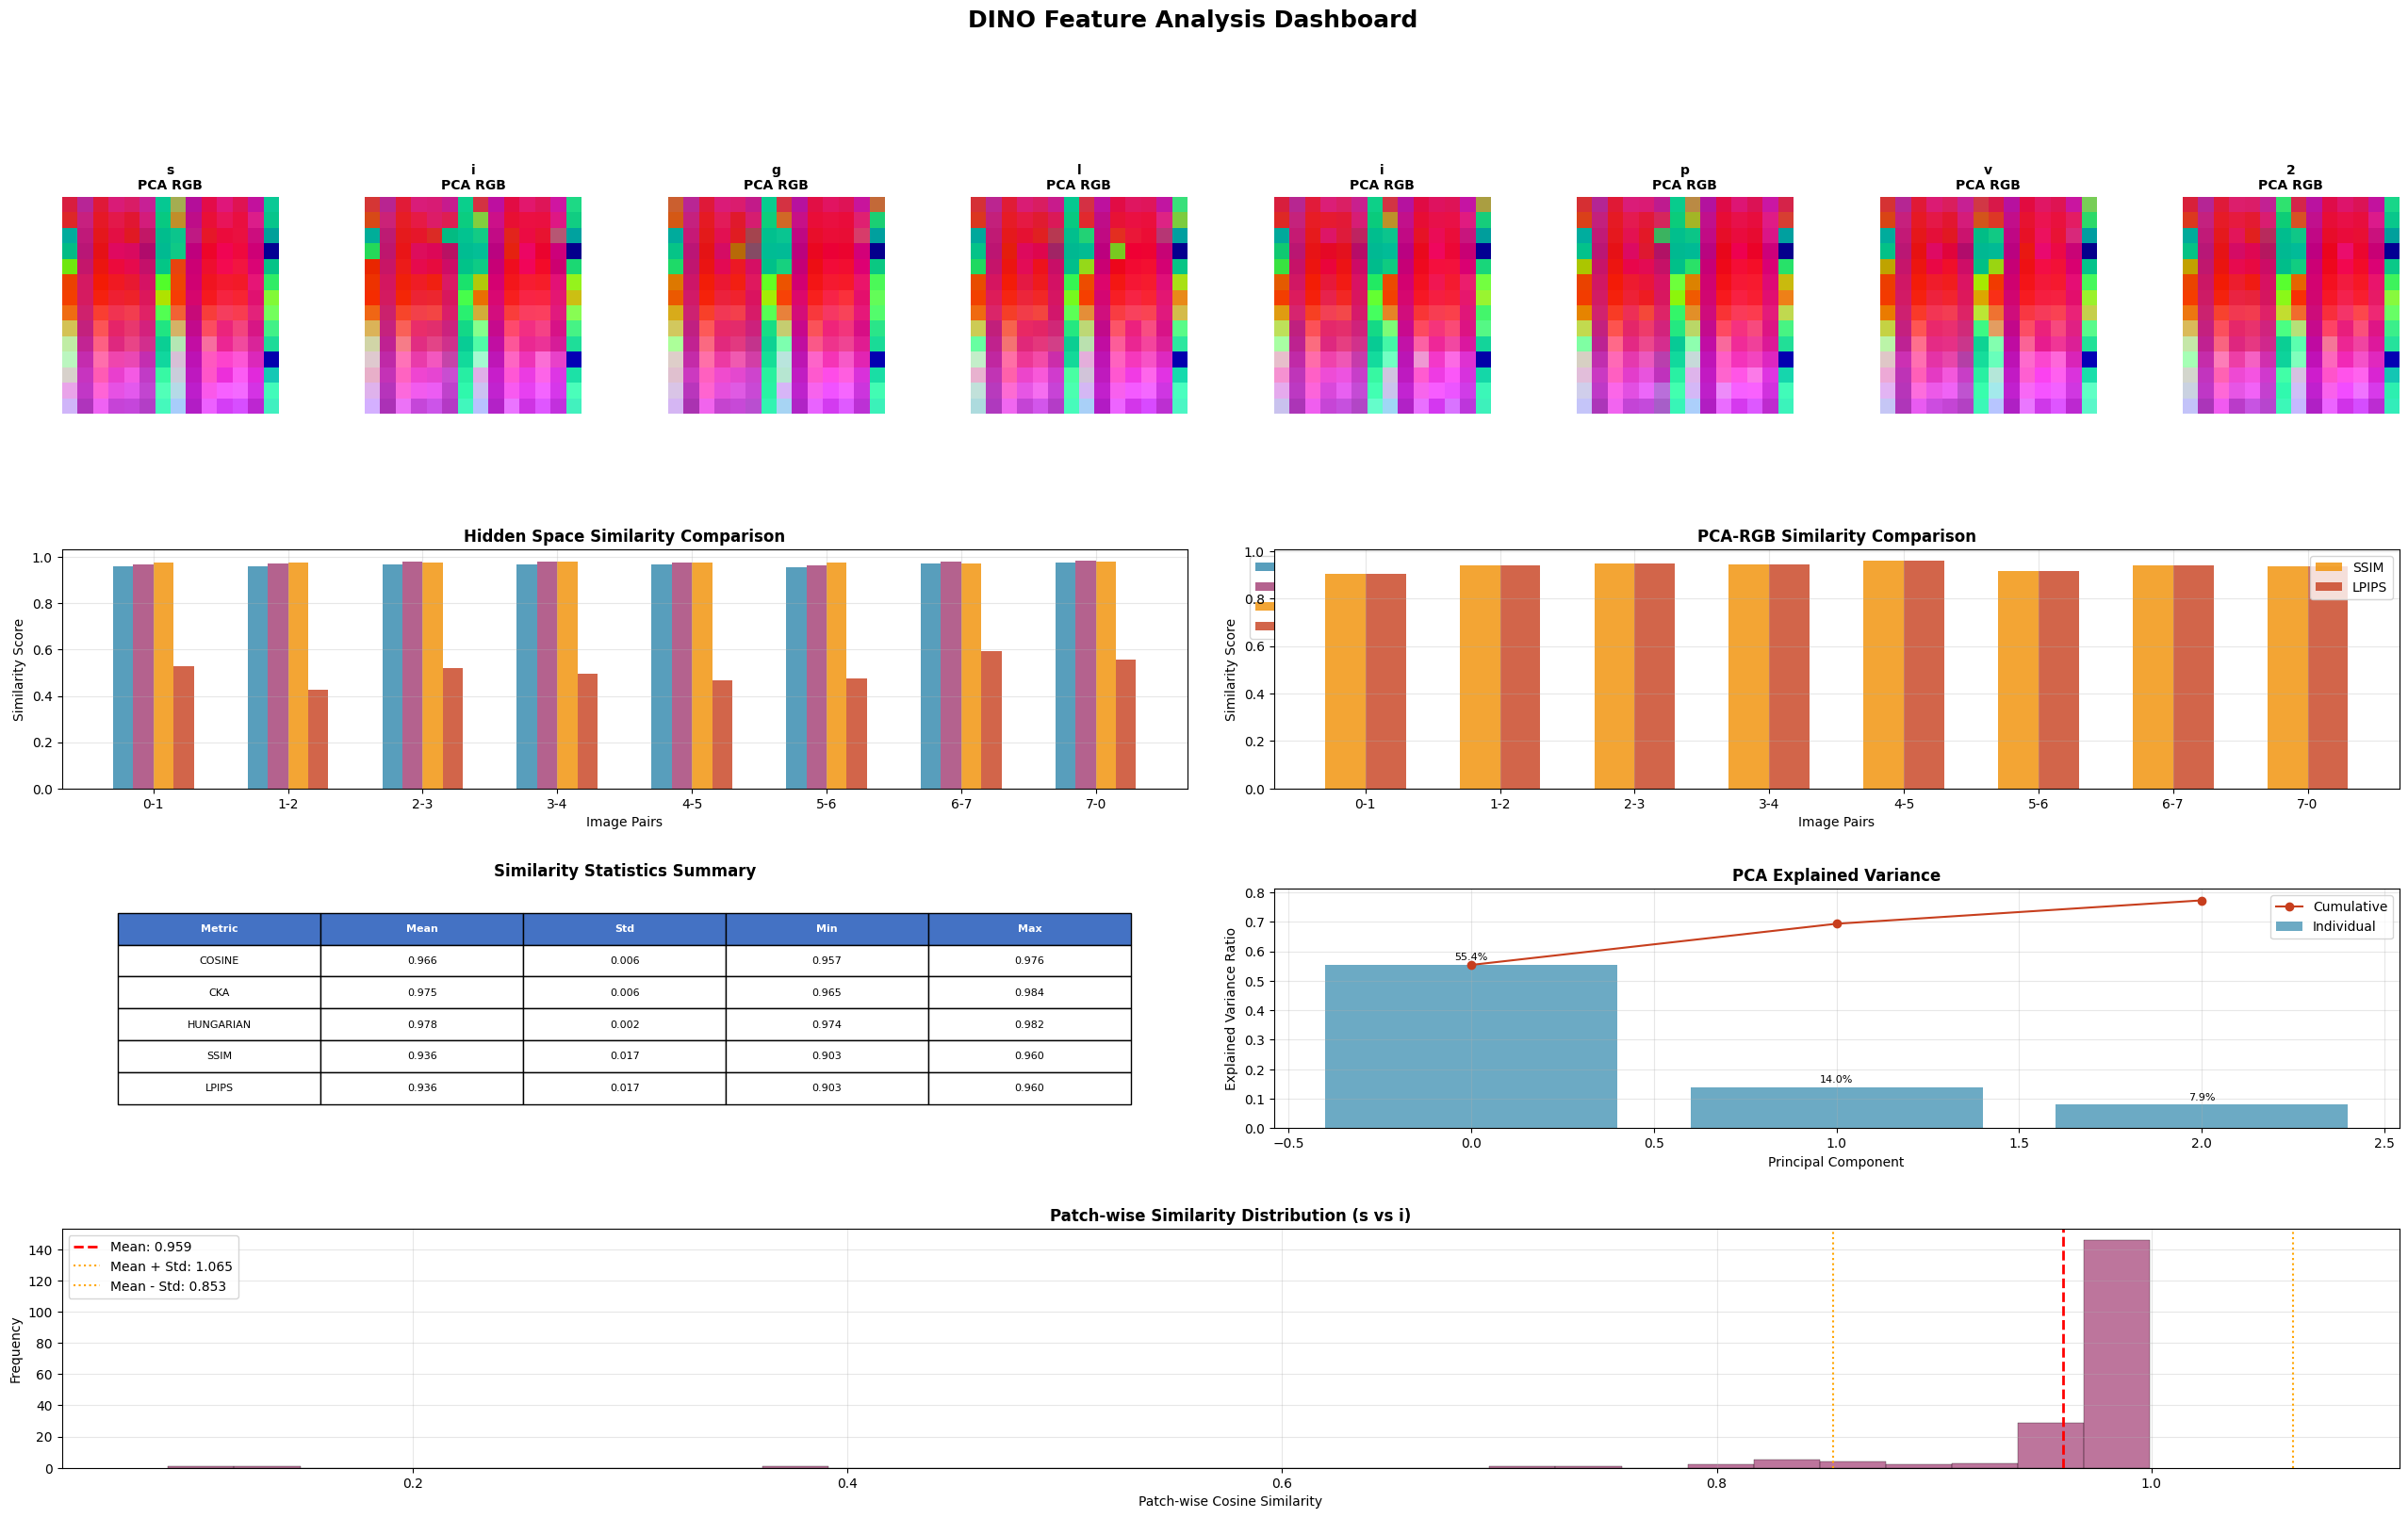

{'hidden_similarity': {'mse': [np.float32(0.08133767),
   np.float32(0.07774413),
   np.float32(0.062065266),
   np.float32(0.06412628),
   np.float32(0.067128114),
   np.float32(0.08544175),
   np.float32(0.058730014),
   np.float32(0.04783166)],
  'cosine': [0.9593310356140137,
   0.961127758026123,
   0.9689672589302063,
   0.9679367542266846,
   0.9664359092712402,
   0.9572790265083313,
   0.970634937286377,
   0.9760841727256775],
  'cka': [0.9698894023895264,
   0.9709364175796509,
   0.9787884950637817,
   0.9784645438194275,
   0.9767196178436279,
   0.9650208950042725,
   0.9789235591888428,
   0.9842493534088135],
  'hungarian': [0.9751406311988831,
   0.9759843945503235,
   0.9777707457542419,
   0.9792566299438477,
   0.9781811833381653,
   0.977977991104126,
   0.9741799235343933,
   0.9822761416435242],
  'warp_ocs': [0.5271267890930176,
   0.4247312545776367,
   0.5184814929962158,
   0.49633586406707764,
   0.46710139513015747,
   0.47586527466773987,
   0.594092071056

In [4]:
from panovlm.vis.dino import DinoVisualizer
visualizer = DinoVisualizer(last_hidden_states,remove_cls_token=False)
visualizer.fit_pca(use_global_scaling=True)
visualizer.get_hidden_similarity()
metadata = img_proc.view_metadata  # E2P에서 자동 생성
similarity = visualizer.get_hidden_similarity(
    pairs=[(0, 1)], view_metadata=metadata
)
visualizer.plot_pca_results(
    titles=checkpoint_path.split("/")[1],
    save_path=f"{checkpoint_path.split("/")[1]}.png",
    )

visualizer.create_comprehensive_dashboard(
    titles=checkpoint_path.split("/")[1],
    view_metadata=metadata,
    save_path=f"{checkpoint_path.split('/')[1]}_dashboard.png"
)